# Segmenting video game consumers according to their personality

This project was conducted as part of my Master 2 Economics thesis at the Université Paris-I Panthéon-Sorbonne and the Paris School of Economics. The idea behind this project was to link personality traits and the most salient video game genres. In this way, it would demonstrate that segmenting consumers according to their personality is a relevant strategy. Such an approach would allow companies to be more competitive, maximize their sales and satisfy their personality segmented consumers by advertising relevant and appropriate video games. 

The problem is that giving a genre to a game is a difficult task and is more often imposed by journalists than by players. Therefore, if a discrepancy occurs in the definitions given between the two actors, it could harm a possible marketing campaign made beforehand. Therefore, it seemed important to collect and analyze how the main stakeholders, the players, described their games themselves, and then to link these dimensions to the personality of the players.

In other words, the goal of this project was threefold:


1.   Develop a new nomenclature of the main video game genres via millions of reviews and a topic-modelling approach (LDA)
2. Conduct an experiment to collect the personality of the subjects and their preferences towards the new genres found in (1)
3. Develop models to predict the preferences of the main genres in games based on their personality traits



The interactive version of this project can be found on this Jupyter notebook: https://colab.research.google.com/drive/1BBABJiOgukGEaAJEVWFfFutUinNlxHMw?usp=sharing

The GitHub related to this project can be found here: https://github.com/Arkhemis/M2_EcoPsycho_Thesis

# Importation of the libraries necessary for the project



In [ ]:
# Pre-processing part
import re 
import string
import pandas as pd 
import numpy as np
import nltk
import spacy
import detect #Detecting language used
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) #Remove warnings

# To replicate results
nlp_model = spacy.load('en_core_web_sm')
nlp_model.max_length = 1000000000
SEED = 1962
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

# LDA / topic-modeling
from gensim.models import CoherenceModel
from pprint import pprint
from gensim.models.wrappers import LdaMallet
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
from gensim.utils import simple_preprocess
import matplotlib.plotly as plt

#Statistical analysis
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

# Data collection and cleaning

## Extracting data (Reviews) from Steam

The data needed to infer the video game topics (video game reviews written in English) were collected using a web crawler on Steam, a platform for video game distribution. The scripts used in the design of the crawler can be found on the corresponding GitHub repository: https://github.com/Arkhemis/steam-crawler.


In total, **12,758,976 reviews**, written by 5,868,265 unique users and spread over 32,788 different games were collected by our crawler. The table below shows a sample of the collected metadata.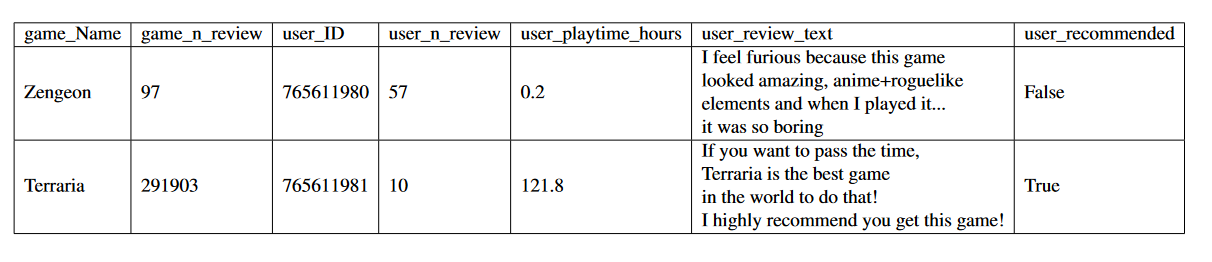



## Data cleaning

A process of tokenization, stop-word cleaning, non-alphabetic characters and lemmatization was performed, in order to standardize the dataset. The graph below shows the pre-processing process. 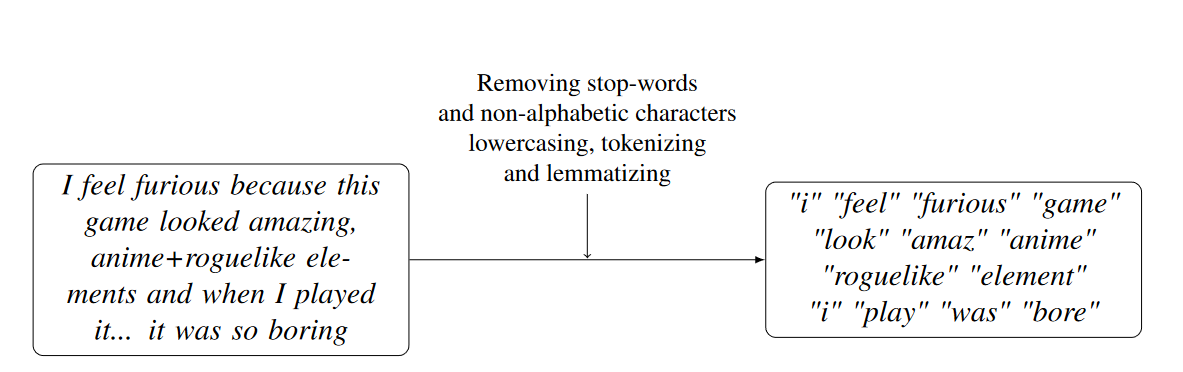
In addition, the Python package LangDetect from Google was used to remove any reviews written in a language other than English. The following functions were developed for this purpose. Reviews with less than 2 hours of playing time at the time of publication, as well as very short reviews (> 5 words) were also removed.

In [ ]:
def clean_text(text, tokenizer, stopwords):
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"<a[^>]*>(.*?)</a>", r"\1", text) #Remove html tags
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation
    doc = nlp_model(text)
    tokens = [token.lemma_ for token in doc]
    #tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens #Clean the Text

def custom_detect(x):
    try:
        return detect(x)=='en'
    except:
        return False

df = pd.read_csv("reviews.csv")
df = df[df['user_review_text'].apply(lambda x: (len(x.split(' ')) >= 5) and custom_detect(x))]
df = df[(df.user_playtime >= 2)] #Remove users with less than 2 hours of playtime
df["tokens"] = df["user_review_text"].map(lambda x: clean_text(x, word_tokenize, custom_stopwords))
df.to_csv('df_review_cleaned.csv', index = False)

This procedure reduced the number of critics to **4,892,472** (2,793,097 unique users and 1095 different games), or 38% of our initial dataset.

# Topic modeling

## Evaluation of the coherence score

To find the most important topics, a topic modeling approach with Latent Dirichlet Allocation (LDA) was used. First, a consistency score evaluation was used to determine the number of topics to specify upstream. This score represents the performance of the model in producing human interpretable topics, and the number of topics to choose corresponds to the moment when the score starts to decrease.


In [ ]:
os.environ.update({'MALLET_HOME':r'./mallet'})
mallet_path = './mallet/bin/mallet' # update this path

#Defining a function that will compute coherence scores for our corpus
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed = SEED)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_val = coherencemodel.get_coherence()
        coherence_values.append(coherence_val)
        print("num_topics = ",num_topics, "has a coherence of:", coherence_val)

    return coherence_values

coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=50, limit=100, step=5)

#Plotting the results
plt.plot(np.arange(2,20,2), coherence_values[:9], label="c")
plt.xlabel("Num Topics")
plt.ylabel("Coherenc score")
plt.legend(loc='best')
plt.show()

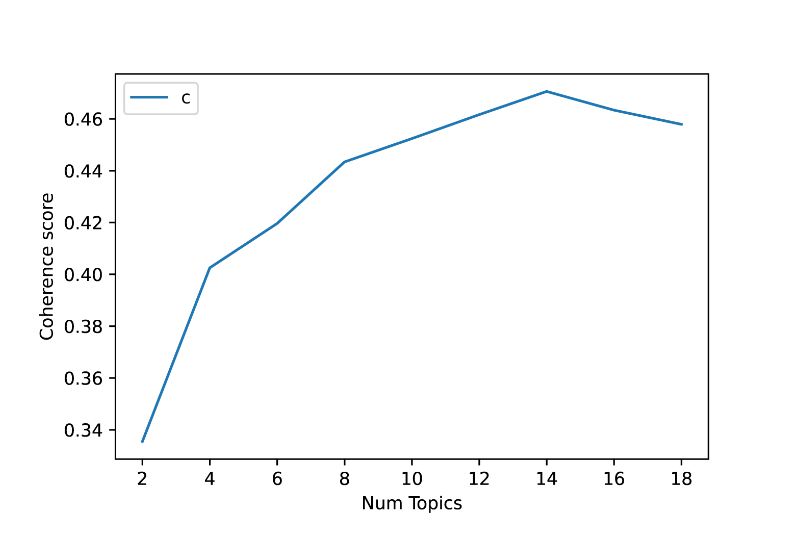

Once put in graphical form, we can see that the number of topics to specify for our model was 14 topics. It is therefore with this number that the model was trained.

## Training of the LDA model and visualization of topics

In [ ]:
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'./mallet'})
mallet_path = './mallet/bin/mallet' # update this path


lda_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=14, id2word=id2word, random_seed = SEED)

lda_model_vis = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model) #Forced to convert the model to display the graph below
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_vis, corpus, id2word)
doc_lda = lda_model_vis[corpus]

pprint(lda_model.print_topics(num_words=50))
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10    -0.219969  0.089044       1        1  8.369980
4     -0.197428 -0.098365       2        1  7.896874
6     -0.098424  0.194298       3        1  7.761012
9     -0.220055  0.016484       4        1  7.636740
2     -0.082654  0.191637       5        1  7.478525
8     -0.147665 -0.125419       6        1  7.422221
13     0.057958 -0.157013       7        1  7.117695
11     0.100989  0.009026       8        1  7.025455
0      0.104884 -0.038043       9        1  6.975081
12     0.032896 -0.199786      10        1  6.846841
1      0.017471 -0.117720      11        1  6.651918
7      0.163709  0.200164      12        1  6.533857
3      0.245230 -0.183764      13        1  6.337200
5      0.243058  0.219458      14        1  5.946601, topic_info=      Term          Freq         Total Category  logprob  loglift
157  story  1.369612e+06  1.369612e+06  Default  30.0000  30.0000
302   love  1.030250e+06  1.030250e+06  Default  29.0000  29.0000
611    buy  9.966670e+05  9.966670e+05  Default  28.0000  28.0000
204   hour  1.056164e+06  1.056164e+06  Default  27.0000  27.0000
22   thing  9.931130e+05  9.931130e+05  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
967    top  8.033660e+04  1.534443e+05  Topic14  -4.7006   2.1752
983    ton  6.358388e+04  1.561561e+05  Topic14  -4.9344   1.9239
393    age  5.080051e+04  9.193747e+04  Topic14  -5.1589   2.2291
820  genre  5.089806e+04  1.096096e+05  Topic14  -5.1570   2.0553
52   bring  5.435499e+04  1.712575e+05  Topic14  -5.0912   1.6747

[1087 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
550       1  0.909305   ability
550       3  0.000077   ability
550       4  0.090621   ability
1724      3  0.019253  absolute
1724     10  0.094374  absolute
...     ...       ...       ...
411      13  0.581909      year
411      14  0.022840      year
2217     10  0.999987        yo
530      10  0.000032    zombie
530      11  0.999967    zombie

[2051 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 5, 7, 10, 3, 9, 14, 12, 1, 13, 2, 8, 4, 6])

The graph above represents the **intertopic distance**: the topics that are closest semantically are closer in space, and vice versa. However, not all topics are usable: some of them refer to elements other than the content of the games. Topic 7, which contains words related to bugs and problems encountered, is an example. The table below represents the selected topics.

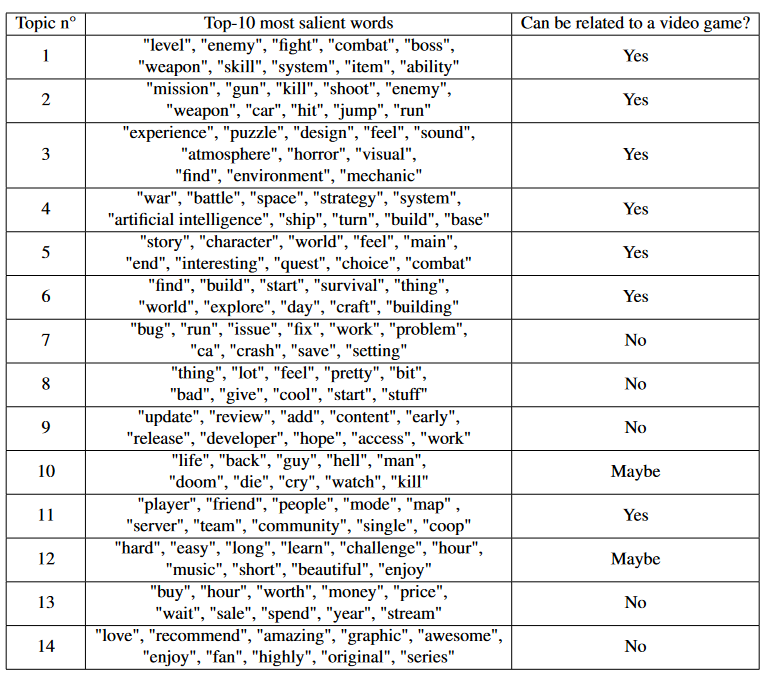

To give clarity and facilitate reading, a name was given to the selected topics, according to the words they contained. Thus, we have 7 different topics: 

1.   $\sim$Challenging
2.   $\sim$Shooter
3.   $\sim$Puzzle 
4.   $\sim$Strategy
5.   $\sim$RolePlay
6.   $\sim$Simulation
7.   $\sim$Multiplayer



# Online experiment

With the topics and their associated words obtained, an online experiment coded with Python was developed. 150 individuals participated in the experiment, which yielded:
1. The personality scores of the subjects (in each of the 5 Big Five traits: Extraversion, Open-mindedness, Neuroticism, Conscientiousness and Agreeableness) 
2. Subjects' preferences towards different video game topics, assessed via a preference ranking. 
3. To collect demographic data (video game player or not, male/female, age).

The experiment is still online and can be played here: https://otree-games-study.herokuapp.com/p/8rs6q0cs/EN_Introduction/Introduction/1/. 

The code used to develop this experiment can be found at this address: 
https://github.com/Arkhemis/M2_EcoPsycho_Thesis/tree/main/OTree_Experiment

# Statistical analysis

To predict video game preferences based on personality scores, 7 logistic regressions, one for each topic, were conducted. As shown in the output below, the variance inflation factors were very low, demonstrating that there was no multicollinearity (the correlation between our predictor variables) for each of our models.




In [ ]:
def make_dfinal(df):
    df_trick = df.copy() 
    cat_vars=["Age_Range", "Personality","Discipline",	"Joueur",	"Gender",	\ 
              "CSP",	"Education",	"Location"]
    for var in cat_vars:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(df_trick[var], prefix=var)
        data1=df_trick.join(cat_list)
        df_trick=data1
    data_vars=df_trick.columns.values.tolist()
    to_keep=[i for i in data_vars if i not in cat_vars]
    data_final=df_trick[to_keep]
    return data_final

df = pd.read_csv("df_complet.csv")

## CHECK Multicollinearity #####
cols=['Age', 'OPE', 'AGR', 'CON', 'NEU', 'EXT',
       'Gender_Femme', 'Joueur_1.0']
data_final = make_dfinal(df)
data_final = data_final[cols]
X = add_constant(data_final)
vif = pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)
round(vif,2)

const           113.42
Age               1.12
OPE               1.15
AGR               1.29
CON               1.20
NEU               1.22
EXT               1.15
Gender_Femme      1.43
Joueur_1.0        1.34
dtype: float64

During the experiment, we had collected a ranking of the topics' preferences by the subjects. The subjects had to rank the topics by order of preference, from 1 (very strong preference) to 7 (very weak preference).

Thus, 7 logit regressions were conducted. The predictor variables were personality scores, age, gender, and whether or not they played video games. The predictor variable was a binary variable, taking 1 if the game was ranked first and 0 otherwise.

In [ ]:
#LOGIT
data_final = make_dfinal(df)
for type_game in WTPlay:
    data_final[str(type_game)] = np.where(data_final[str(type_game)]==1, 1, 0)
    X=data_final[cols]
    X["constant"] = 1
    y=data_final[str(type_game)]
    logit_model=sm.Logit(y,X)
    result=logit_model.fit_regularized(maxiter=10000, method='l1_cvxopt_cp', disp=0)
    print(result.summary2())

                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.274     
Dependent Variable:  WTPlay_Souls     AIC:              103.5292  
Date:                2021-09-24 10:51 BIC:              130.6249  
No. Observations:    150              Log-Likelihood:   -42.765   
Df Model:            8                LL-Null:          -58.901   
Df Residuals:        141              LLR p-value:      8.3212e-05
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      nan                                          
------------------------------------------------------------------
              Coef.   Std.Err.    z    P>|z|    [0.025     0.975] 
------------------------------------------------------------------
Age           -0.1456   0.0664 -2.1927 0.0283    -0.2757   -0.0154
OPE            0.0573   0.0511  1.1208 0.2624    -0.0429    0.1575
AGR            0.0823   0.0598  1.3758 0.1689    -0.0350    0.1996
CON            0.0688

# Results Discussion

What interested us in this project was to determine whether personality traits contributed **significantly ($p<0.1$)** to predicting the way in which one type of game is ranked (and therefore favoured) over another. Thus, in view of the results obtained, it can be observed:


* That having a high Extraversion score is positively associated with the preference for Shooter ($p<0.05$) and Multiplayer ($p<0.001$) games
* That a high score in Openness to Experience positively predicted preference for Strategy ($p<0.05$) and Simulation ($p<0.05$) games
* That a high score in Agreeableness positively predicted preference for Role Playing games ($p<0.1$)
* That high Conscientiousness individuals favored Shoot games ($p<0.001$)
* And finally, a high Neuroticism score positively predicted a preference for Multiplayer games ($p<0.1$)


# Conclusion

To summarize, this project has allowed:
* Developed a new nomenclature of game themes, developed from millions of reviews written by millions of different users. 
* This nomenclature allows to provide game themes that are much closer to the vocabulary of the players than a manually made classification would be. 
* Moreover, because LDA modeling allows for flexibility, this nomenclature can be easily updated when new game concepts appear in the players' vocabulary.

This project also has an important practical dimension, residing in its use by video game companies. By providing evidence on which personality trait segments are more likely to be receptive to a given video game and its advertising, companies can:
* Use and implement these findings to be more competitive
* Allocate their resources more optimally
* Develop a more effective marketing campaign 
* Create a deeper affinity with customers. 

By framing their ads with vocabulary that aligns with consumer personality segments, marketers could expose consumers to games they are more likely to enjoy, thereby increasing their utility. 

Of course, personality is just one of many psychological metrics that can be used to better understand the consumer and their intentions. For example, one could just as easily imagine a study to understand the link between values (religiosity, altruism, lifestyle...) and preferences towards virtual goods. This would allow, as this project did here, to better explain and understand what motivates consumers in their preferences on cultural goods around us.